<a href="https://colab.research.google.com/github/pat-olhed/Store_Forecast_TSA/blob/main/store_data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install gdown: do this only once. The line of code is commented so if we "run all" it doesnt try to install it again
# !pip install -U gdown

In [2]:
#!pip install statsmodels

# Reading the data

If the kernel disconnects, simply run the cell below and use the read_pickle() function to reload the appropriate train file, choosing the version that matches the stage of the EDA process you're currently at.
This allows you to pick up right where you left off without repeating all previous steps.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import gdown

# Build the download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

def read_metadata_files(file_ids):
  # Read all files but train.csv
  # Load each CSV using the helper functions
  df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
  df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
  df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
  df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
  df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))
  return df_holiday_events, df_items, df_oil, df_stores, df_transactions

# Dictionary of file IDs
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

df_holiday_events, df_items, df_oil, df_stores, df_transactions = read_metadata_files(file_ids)

Only run the cell below the first time. After that, you can just load the saved file using read_pickle() whenever you return to your notebook or the kernel restarts.

In [4]:
# Download the train.csv file using gdown
train_url = make_drive_url(file_ids["train"])
gdown.download(train_url, "train.csv", quiet=False)

# Load stores and get Guayas store IDs
stores_url = make_drive_url(file_ids["stores"])
df_stores = pd.read_csv(io.StringIO(requests.get(stores_url).text))
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Read train.csv in chunks and filter for Guayas region
chunk_size = 10**6
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size):
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    filtered_chunks.append(chunk_filtered)
    del chunk

# Combine and sample
df_train = pd.concat(filtered_chunks, ignore_index=True)
# Clean up memory
del filtered_chunks

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=5c7d2beb-5255-4b5f-8874-d5e88ef8f479
To: /content/train.csv
 31%|███       | 1.54G/5.00G [00:16<00:30, 113MB/s]

KeyboardInterrupt: 

In [ ]:
df_train.head()

In [ ]:
df_train.shape

In [ ]:
# Compute the number of items per family and select the top 3 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # Keep only the top 3 families

item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

In [ ]:
# Save df_train as a pickle file to avoid reloading it once colab disconnects
# 1.  Mount Drive (one-time click to authorize)
from google.colab import drive
drive.mount('/content/drive')

# 2.  Pick a folder inside Drive (create it if it doesn’t exist)
save_path = "/content/drive/MyDrive/Store_Forecast_TSA/data//df_train_original.pkl"

# 3.  SAVE the cleaned DataFrame
df_train.to_pickle(save_path)
print(f"Saved to: {save_path}")


In [24]:
from google.colab import drive
drive.mount('/content/drive')


df_train = pd.read_pickle("/content/drive/MyDrive/Store_Forecast_TSA/data/df_train_original.pkl")

print(df_train.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(14745768, 6)


# Step 1: Missing values

In [25]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,2747275


In [26]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

/tmp/ipython-input-2380528398.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


In [27]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0


# Step 2: Outliers

In [28]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,-2.0,False
54236,309805,2013-01-09,35,1079215,-8.0,False
64452,382905,2013-01-11,27,1097187,-20.0,False
96414,564108,2013-01-15,51,627885,-36.0,False
132903,787522,2013-01-21,24,211205,-5.0,False


In [29]:
# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

In [30]:
# Checking negative sales got correctly replaced
df_train[df_train['unit_sales'] < 0]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion


In [31]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

# Apply the Z-score calculation to each store-item group,then flatten the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 48485


/tmp/ipython-input-1396708906.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
188,15666702,2013-12-18,24,96995,14.0,False,7.946399
286,59775862,2015-10-20,24,99197,14.0,False,5.822016
289,60322807,2015-10-26,24,99197,19.0,False,8.276173
721,15717753,2013-12-19,24,103520,27.0,False,6.642670
770,18886543,2014-02-13,24,103520,22.0,False,5.154400


# Step 3: Fill missing dates with zero sales

In [32]:
# Make sure the date column is a real datetime
df_train['date'] = pd.to_datetime(df_train['date'])

def fill_calendar(group):
    #
    # group contains all rows for ONE (store_nbr, item_nbr) pair
    #
    g = group.set_index("date").sort_index()   # use calendar as the index
    g = g.asfreq("D", fill_value=0)            # make it daily; add 0 where missing

    # put the identifiers back (asfreq drops them)
    g["store_nbr"] = group["store_nbr"].iloc[0]
    g["item_nbr"]  = group["item_nbr"].iloc[0]

    return g.reset_index()                     # date back to a normal column

df_train = (
    df_train
    .groupby(["store_nbr", "item_nbr"], group_keys=False)  # keeps memory low
    .apply(fill_calendar)
)

df_train.head()

/tmp/ipython-input-554488917.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_calendar)


,date,id,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-01-09,302230,24,96995,2.0,False
1,2013-01-10,0,24,96995,0.0,0
2,2013-01-11,0,24,96995,0.0,0
3,2013-01-12,419989,24,96995,2.0,False
4,2013-01-13,0,24,96995,0.0,0


In [33]:
df_train.shape

(23403660, 6)

# Feature Engineering

In [34]:
# Make sure 'date' is a real datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Split the timestamp into model-friendly parts
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek # Monday=0 … Sunday=6

In [35]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week
0,2013-01-09,302230,24,96995,2.0,False,2013,1,9,2
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4
3,2013-01-12,419989,24,96995,2.0,False,2013,1,12,5
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6


In [ ]:
# 7-day rolling average of unit_sales, per (item, store)
df_train = df_train.sort_values(["item_nbr", "store_nbr", "date"]).reset_index(drop=True) # make sure rows are in time order

df_train["unit_sales_7d_avg"] = (
    df_train
    .groupby(["item_nbr", "store_nbr"])["unit_sales"]      # isolate one time-series per (item, store), get the units sold
    .transform(lambda s: s.rolling(window=7, min_periods=1).mean())       #  mean of last 7 days, i.e. 7-day moving average, aligned back to original df
)



In [ ]:
# Get store and item from the first row
store_id = df_train.iloc[0]['store_nbr']
item_id = df_train.iloc[0]['item_nbr']

# Filter the DataFrame for this store-item pair
sample = df_train[(df_train['store_nbr'] == store_id) & (df_train['item_nbr'] == item_id)].sort_values("date")
sample.head()


In [ ]:
# Save df_train as a pickle file to avoid reloading it once colab disconnects
# 1.  Mount Drive (one-time click to authorize)
from google.colab import drive
drive.mount('/content/drive')

# 2.  Pick a folder inside Drive (create it if it doesn’t exist)
save_path = "/content/drive/MyDrive/Store_Forecast_TSA/data/df_train_clean.pkl" # example of path

# 3.  SAVE the cleaned DataFrame
df_train.to_pickle(save_path)
print(f"Saved to: {save_path}")

In [3]:
# ---------------------------------------------------------------
# When you come back to this notebook (or if the session resets):
#
# 1. First, run the setup cell with all the imports and helper functions.
# 2. Then run the lines below to load your saved dataset.
#
# Just change the pickle filename to match the version you saved earlier.
# ---------------------------------------------------------------

from google.colab import drive
drive.mount('/content/drive')
load_path = "/content/drive/MyDrive/Store_Forecast_TSA/data/df_train_clean.pkl"
df_train = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame reloaded, ready to go!


# Step 5: Visualizing Time-Series Data

## a) Sales Over Time (Aggregated)

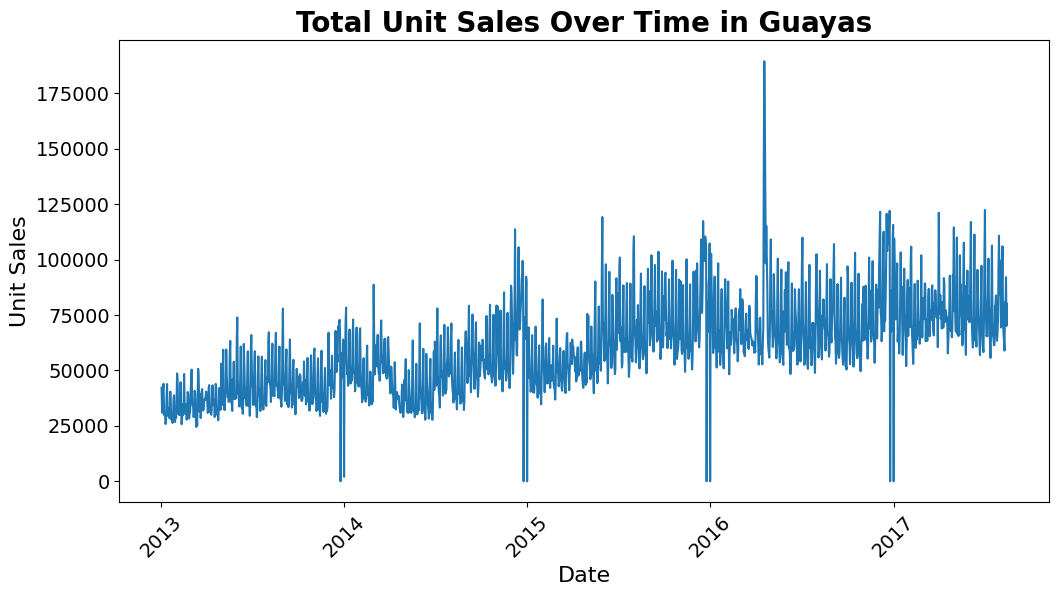

In [4]:
import matplotlib.pyplot as plt

# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

## b) Sales Trend by Year and Month

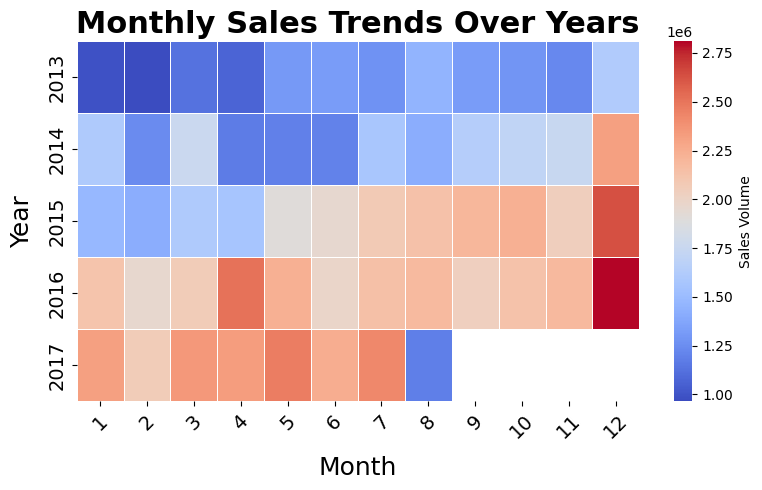

In [5]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Plotting heatmap of sales by year and month
import seaborn as sns

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility

sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

# Step 6: Examining the Impact of Holidays. Do holidays boost or hurt sales?

In [6]:
df_holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
# Convert date column to datetime
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
print(
    "Holiday file covers:",
    df_holiday_events['date'].dt.date.min(), "→",
    df_holiday_events['date'].dt.date.max()
)

Holiday file covers: 2012-03-02 → 2017-12-26


In [8]:
# Join holidays onto our sales table
df_train_holiday = pd.merge(
    df_train,                     # daily sales
    df_holiday_events[['date', 'type']],  # keep only what we need
    on='date',
    how='left'                    # non-holiday days get NaN in 'type'
)
df_train_holiday.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,type
0,2013-01-09,302230,24,96995,2.0,False,2013,1,9,2,2.000000,NaN
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,1.000000,NaN
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,0.666667,NaN
3,2013-01-12,419989,24,96995,2.0,False,2013,1,12,5,1.000000,Work Day
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,0.800000,NaN


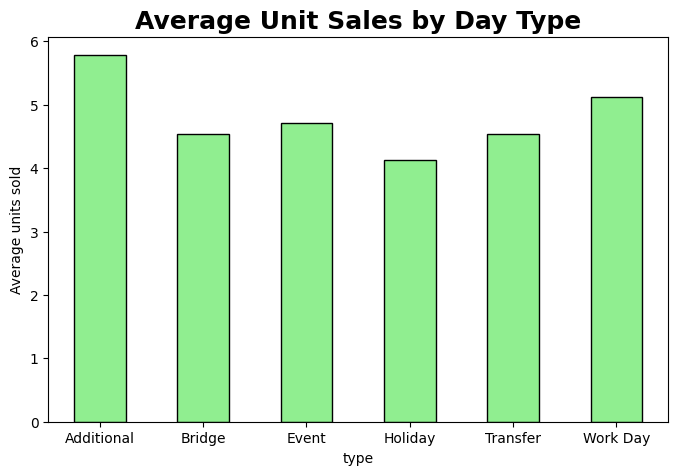

In [9]:
# Compare average sales for each holiday type
# 1–2  average units sold for each day-type
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# 3  bar chart
holiday_sales.plot(kind='bar', figsize=(8,5), color='lightgreen', edgecolor='black')
plt.title('Average Unit Sales by Day Type', fontsize=18, weight='bold')
plt.ylabel('Average units sold')
plt.xticks(rotation=0)
plt.show()

# Step 7: Analyzing Perishable Items

In [11]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [12]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
df_train_items.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,family,class,perishable
0,2013-01-09,302230,24,96995,2.0,False,2013,1,9,2,2.000000,GROCERY I,1093,False
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,1.000000,GROCERY I,1093,False
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,0.666667,GROCERY I,1093,False
3,2013-01-12,419989,24,96995,2.0,False,2013,1,12,5,1.000000,GROCERY I,1093,False
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,0.800000,GROCERY I,1093,False


In [13]:
df_train_items['perishable'].value_counts()

,count
perishable,
False,23403660


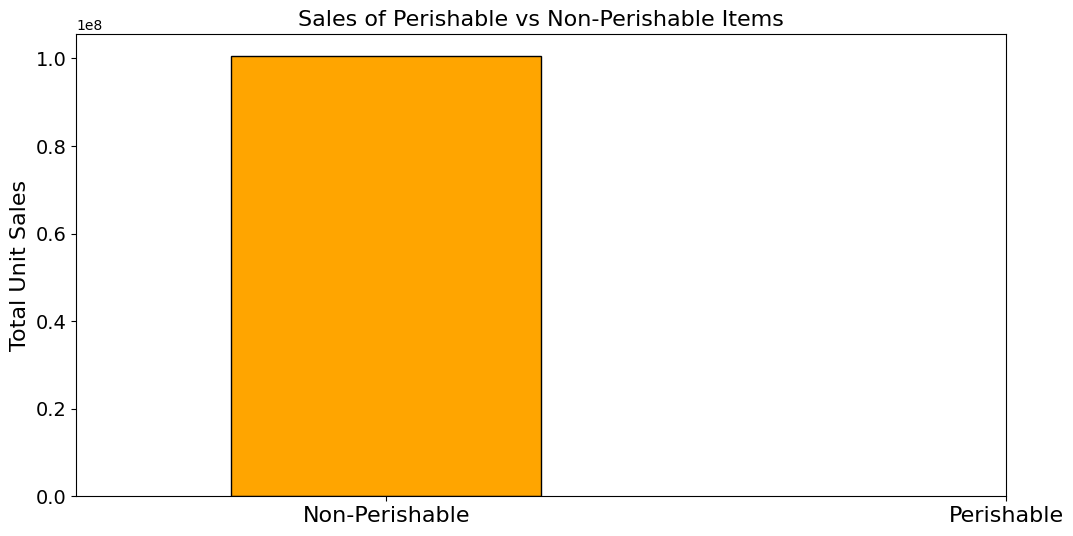

In [14]:
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(12,6))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()

# Step 8: Investigating Relationship with Oil Prices

df_train is huge; merging every row with df_oil duplicates the oil price for every individual sale, which eats RAM fast.

For the oil-vs-sales plot you only need one sales total per day, not every store-item row.

So aggregate first (shrinks the table ~100×), then merge—same visual result, a fraction of the memory.

In [15]:
# Make sure the date column is a real datetime
df_oil['date'] = pd.to_datetime(df_oil['date'])

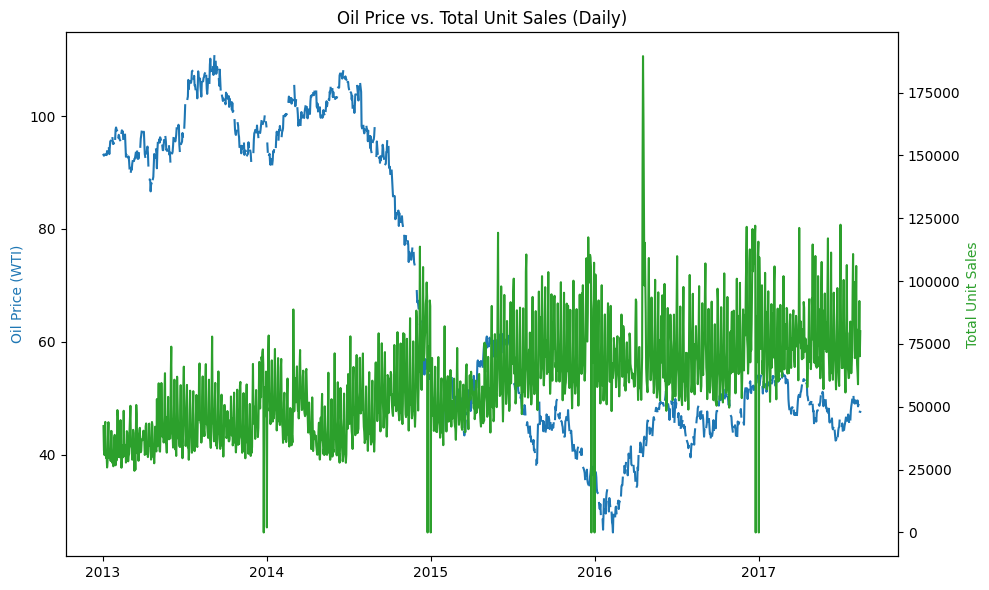

In [16]:
# Aggregate sales to daily total  →  tiny DataFrame
daily_sales = (
    df_train
      .groupby('date', as_index=False)['unit_sales']
      .sum()
)

# Merge on date (now only ~1,500 rows instead of millions)
daily_sales_oil = daily_sales.merge(df_oil, on='date', how='left')

# Plot
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(daily_sales_oil['date'], daily_sales_oil['dcoilwtico'],
         color='tab:blue', label='Oil Price')
ax1.set_ylabel('Oil Price (WTI)', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(daily_sales_oil['date'], daily_sales_oil['unit_sales'],
         color='tab:green', label='Unit Sales')
ax2.set_ylabel('Total Unit Sales', color='tab:green')

plt.title('Oil Price vs. Total Unit Sales (Daily)')
plt.tight_layout()
plt.show()


# Autocorrelation and Stationarity

### Autocorrelation

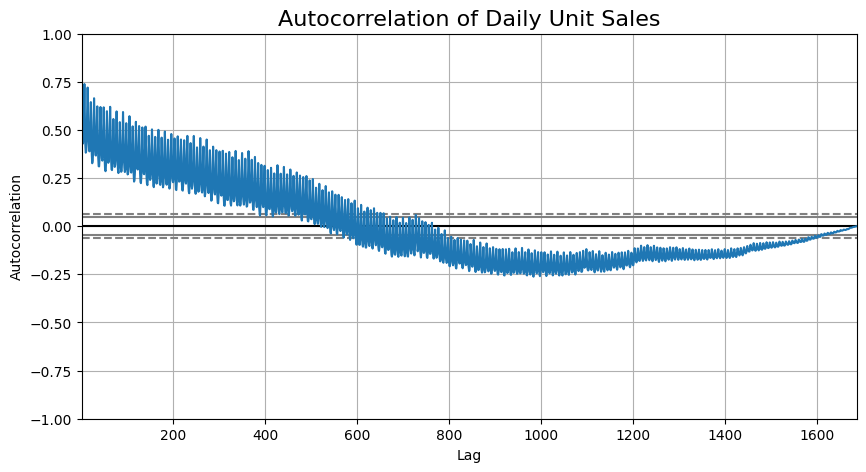

In [17]:
from pandas.plotting import autocorrelation_plot

# Aggregate total sales per day
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plot autocorrelation
plt.figure(figsize=(10, 5))
autocorrelation_plot(sales_by_date)
plt.title('Autocorrelation of Daily Unit Sales', fontsize=16)
plt.show()


### Stationarity

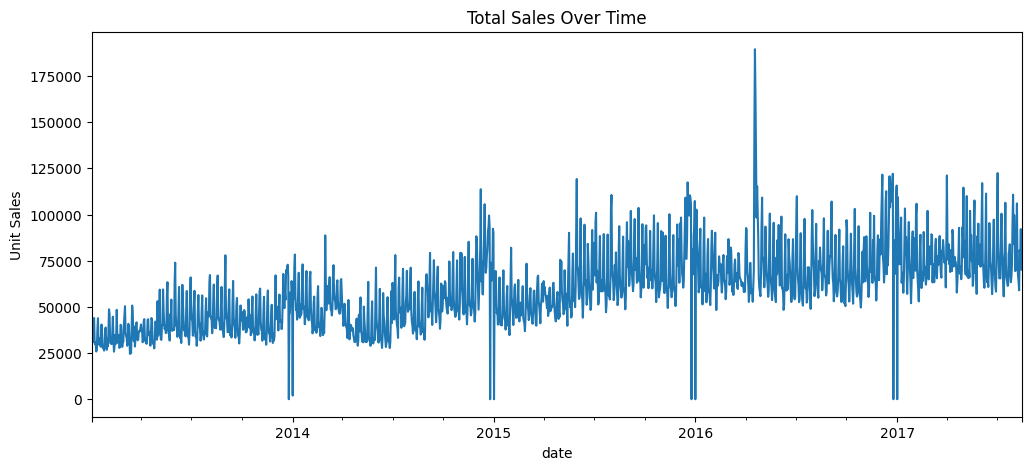

In [18]:
# Visual check
sales_by_date.plot(figsize=(12,5), title='Total Sales Over Time')
plt.ylabel('Unit Sales')
plt.show()


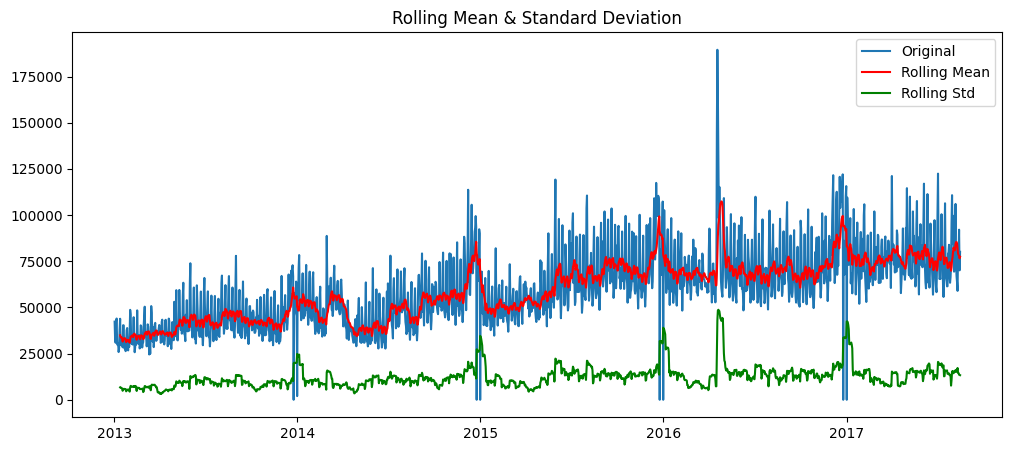

In [19]:
rolling_mean = sales_by_date.rolling(window=12).mean()
rolling_std = sales_by_date.rolling(window=12).std()

plt.figure(figsize=(12,5))
plt.plot(sales_by_date, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()


In [20]:
# Statistical test: Augmented Dickey-Fuller (ADF)

from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_by_date)
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -2.874804552839226
p-value: 0.048357313375354836


Here’s the code to diagnose trend and seasonality in a time series using both seasonal_decompose() and STL, including how to measure the strength of trend and seasonality.

STL Decomposition (more robust and recommended)

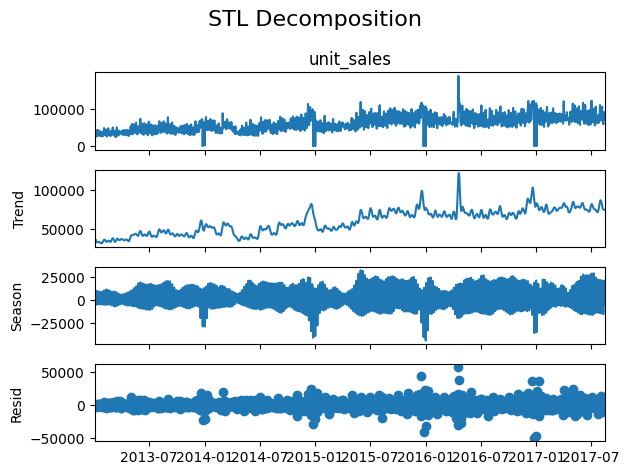

In [22]:
from statsmodels.tsa.seasonal import STL

# STL decomposition
stl = STL(sales_by_date, period=7)  # again, adjust period based on your seasonality
res = stl.fit()

# Plot STL decomposition
res.plot()
plt.suptitle("STL Decomposition", fontsize=16)
plt.tight_layout()
plt.show()


Measure Strength of Trend and Seasonality

In [23]:
# Calculate strength of trend and seasonality
# Based on Hyndman’s definition: Strength = 1 - (variance of remainder / variance of (component + remainder))

import numpy as np

trend_strength = 1 - (np.var(res.resid) / np.var(res.trend + res.resid))
seasonal_strength = 1 - (np.var(res.resid) / np.var(res.seasonal + res.resid))

print(f"Strength of Trend: {trend_strength:.2f}")
print(f"Strength of Seasonality: {seasonal_strength:.2f}")


Strength of Trend: 0.87
Strength of Seasonality: 0.75


**How to Interpret Strength Values:**

*   Close to 1.00 → very strong trend/seasonality

*   Close to 0.00 → weak or no trend/seasonality





This helps you decide if you need to:

*   Remove trend (e.g., differencing)

*   Remove seasonality (e.g., seasonal differencing or modeling with SARIMA)